In [26]:
import os
import sys
TOOLS_PATH = f"{os.getenv('MASTER_PROJECT_ROOT_FOLDER') or '/home/fne23_stjarnholm/master-project'}/logistics"
sys.path.insert(0, TOOLS_PATH)
from tools import run_tools
import seaborn as sns
import openmc
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

results = []

result_folders = run_tools.get_all_result_dirs()

# Loop over each run number and get the run settings as well as the k-effective
for result_folder in result_folders:
    result_path = f"../results/{result_folder}"
    run_settings = run_tools.load_run_settings_json(result_path)

    statepoint_number = run_settings["active_batch_count"] + run_settings["inactive_batch_count"]
    sp = openmc.StatePoint(f"{result_path}/statepoint.{statepoint_number}.h5")

    result = {
        "k-eff": sp.keff.nominal_value, 
        "k-eff-std": sp.keff.std_dev,  
        "result_path": result_path
    }

    result.update(run_settings)
    
    results.append(result)

In [36]:
# PLOT SETTINGS:
FAST_REACTOR = False

folder_name = f"plots-FAST_REACTOR={FAST_REACTOR}"
os.makedirs(folder_name, exist_ok=True)

def get_filename(plot_type: str, value: str):
    return f"{folder_name}/{plot_type}_{value}-FAST_REACTOR={FAST_REACTOR}.pdf"

# Create a dataframe from the results
df = pd.DataFrame(results)

# Filter for FAST_REACTOR
df = df[df["FAST_REACTOR"] == FAST_REACTOR]

if df.empty:
    raise Exception("No results found!")

df.head()

,k-eff,k-eff-std,result_path,FAST_REACTOR,particle_count,active_batch_count,inactive_batch_count,t_start,t_end,t_elapsed
0,0.965636,0.037655,../results/RUNDATA_R2_1,False,100,10,50,1.675786e+09,1.675786e+09,5.452
1,1.001025,0.017151,../results/RUNDATA_R2_2,False,100,30,50,1.675786e+09,1.675786e+09,5.113
2,0.996800,0.008860,../results/RUNDATA_R2_3,False,100,100,50,1.675786e+09,1.675786e+09,5.804
3,0.986742,0.005139,../results/RUNDATA_R2_4,False,100,300,50,1.675786e+09,1.675786e+09,7.938
4,0.983465,0.002837,../results/RUNDATA_R2_5,False,100,1000,50,1.675786e+09,1.675786e+09,15.177


In [37]:
# pivot the dataframe from long to wide form
pivoted_df_k_eff = df.pivot(index='particle_count', columns='active_batch_count', values='k-eff')
pivoted_df_k_eff_std = df.pivot(index='particle_count', columns='active_batch_count', values='k-eff-std')
pivoted_df_t_elapsed = df.pivot(index='particle_count', columns='active_batch_count', values='t_elapsed')

df["rel_err_k-eff-std"] = 100 * df["k-eff-std"] / df["k-eff"]
pivoted_df_rel_err_k_eff_std = df.pivot(index='particle_count', columns='active_batch_count', values='rel_err_k-eff-std')

df["rho"] = (df["k-eff"] - 1) / df["k-eff"]
df["rho-std"] = df["k-eff-std"] / df["k-eff"]**2

df["rho-pcm"] = 1e5 * df["rho"]
df["rho-std-pcm"] = 1e5 * df["rho-std"]

pivoted_df_rho_pcm = df.pivot(index='particle_count', columns='active_batch_count', values='rho-pcm')
pivoted_df_rho_std_pcm = df.pivot(index='particle_count', columns='active_batch_count', values='rho-std-pcm')

df["rel-err_rho-std"] = np.abs(100 * df["rho-std"] / df["rho"])
pivoted_df_rel_err_rho_std = df.pivot(index='particle_count', columns='active_batch_count', values='rel-err_rho-std')

df.head()

,k-eff,k-eff-std,result_path,FAST_REACTOR,particle_count,active_batch_count,inactive_batch_count,t_start,t_end,t_elapsed,rel_err_k-eff-std,rho,rho-std,rho-pcm,rho-std-pcm,rel-err_rho-std
0,0.965636,0.037655,../results/RUNDATA_R2_1,False,100,10,50,1.675786e+09,1.675786e+09,5.452,3.899498,-0.035587,1.096465,-3558.677494,1.096465e+05,3.081104e+03
1,1.001025,0.017151,../results/RUNDATA_R2_2,False,100,30,50,1.675786e+09,1.675786e+09,5.113,1.713361,0.001023,16.740734,102.346904,1.674073e+06,1.635685e+06
2,0.996800,0.008860,../results/RUNDATA_R2_3,False,100,100,50,1.675786e+09,1.675786e+09,5.804,0.888882,-0.003210,2.768724,-321.045764,2.768724e+05,8.624078e+04
3,0.986742,0.005139,../results/RUNDATA_R2_4,False,100,300,50,1.675786e+09,1.675786e+09,7.938,0.520755,-0.013436,0.387619,-1343.593269,3.876188e+04,2.884942e+03
4,0.983465,0.002837,../results/RUNDATA_R2_5,False,100,1000,50,1.675786e+09,1.675786e+09,15.177,0.288468,-0.016813,0.171601,-1681.270622,1.716014e+04,1.020665e+03


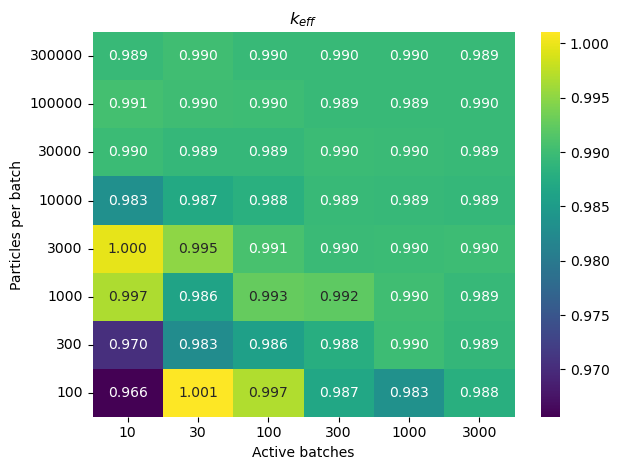

In [38]:
ax = sns.heatmap(pivoted_df_k_eff, annot=True, fmt=".3f", cmap='viridis')
ax.invert_yaxis()
plt.title("$k_{eff}$")
plt.xlabel("Active batches")
plt.ylabel("Particles per batch")
plt.tight_layout()
plt.savefig(get_filename("heatmap", "k_eff"))

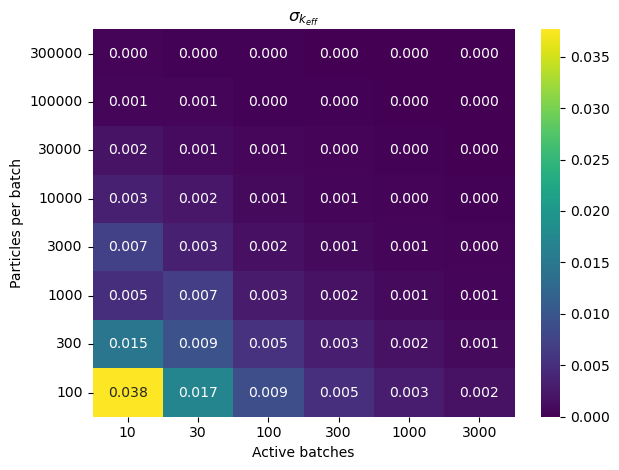

In [39]:
ax = sns.heatmap(pivoted_df_k_eff_std, annot=True, fmt=".3f", cmap='viridis', vmin=0)
ax.invert_yaxis()
plt.title("$\sigma_{k_{eff}}$")
plt.xlabel("Active batches")
plt.ylabel("Particles per batch")
plt.tight_layout()
plt.savefig(get_filename("heatmap", "k_eff_std"))

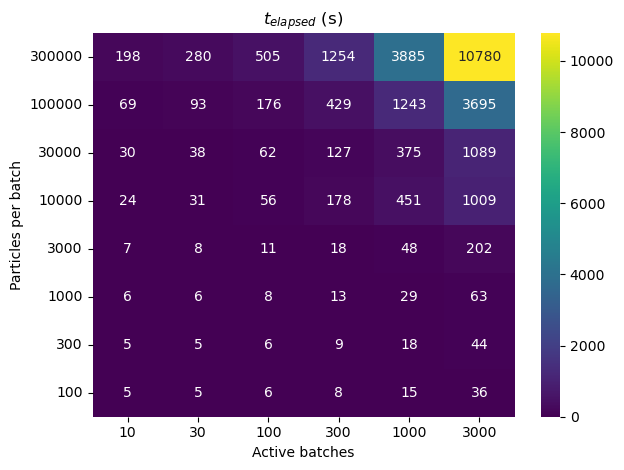

In [40]:
ax = sns.heatmap(pivoted_df_t_elapsed, annot=True, fmt=".0f", cmap='viridis', vmin=0)
ax.invert_yaxis()
plt.title("$t_{elapsed}$ (s)")
plt.xlabel("Active batches")
plt.ylabel("Particles per batch")
plt.tight_layout()
plt.savefig(get_filename("heatmap", "t_elapsed"))

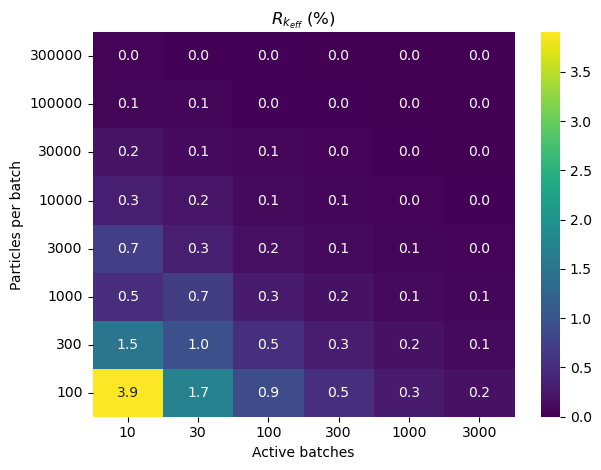

In [41]:
ax = sns.heatmap(pivoted_df_rel_err_k_eff_std, annot=True, fmt=".1f", cmap='viridis', vmin=0)
ax.invert_yaxis()
plt.title("$R_{k_{eff}}$ (%)")
plt.xlabel("Active batches")
plt.ylabel("Particles per batch")
plt.tight_layout()
plt.savefig(get_filename("heatmap", "rel-err-k_eff_std"))

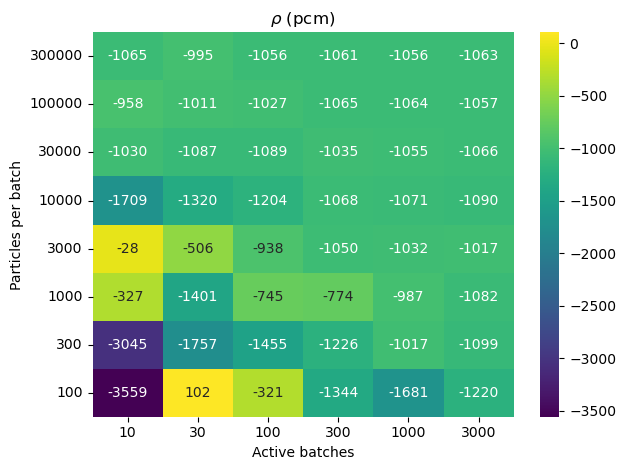

In [42]:
ax = sns.heatmap(pivoted_df_rho_pcm, annot=True, fmt=".0f", cmap='viridis')
ax.invert_yaxis()
plt.title(r"$\rho$ (pcm)")
plt.xlabel("Active batches")
plt.ylabel("Particles per batch")
plt.tight_layout()
plt.savefig(get_filename("heatmap", "rho_pcm"))

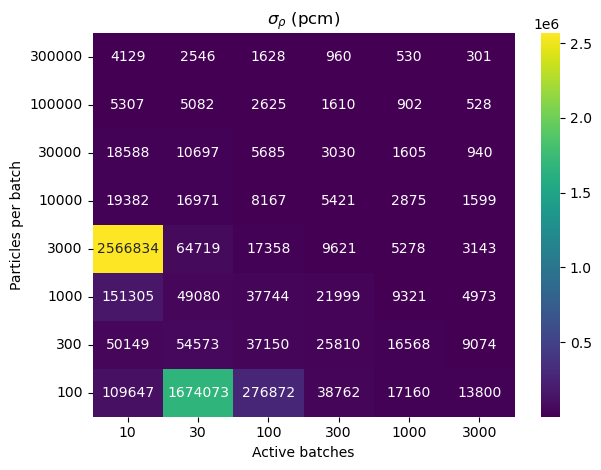

In [43]:
ax = sns.heatmap(pivoted_df_rho_std_pcm, annot=True, fmt=".0f", cmap='viridis')
ax.invert_yaxis()
plt.title(r"$\sigma_{\rho}$ (pcm)")
plt.xlabel("Active batches")
plt.ylabel("Particles per batch")
plt.tight_layout()
plt.savefig(get_filename("heatmap", "rho_std_pcm"))

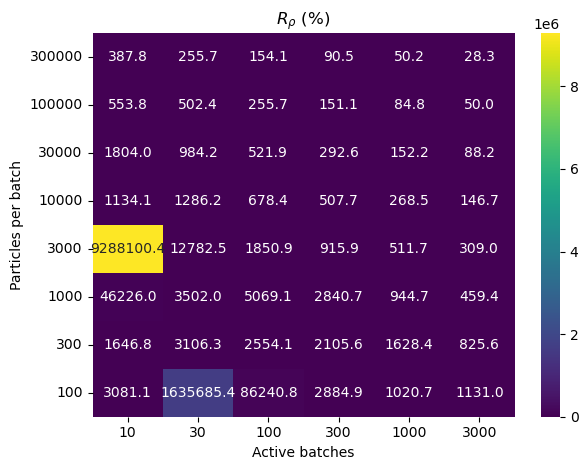

In [44]:
ax = sns.heatmap(pivoted_df_rel_err_rho_std, annot=True, fmt=".1f", cmap='viridis', vmin=0)
ax.invert_yaxis()
plt.title(r"$R_{\rho}$ (%)")
plt.xlabel("Active batches")
plt.ylabel("Particles per batch")
plt.tight_layout()
plt.savefig(get_filename("heatmap", "rel-err-rho_std"))